In [ ]:
'Avd'.lower()

In [ ]:

from global_vars import *
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os
from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [ ]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/KORA'))
data_dir

In [ ]:
def load_kora_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if vol == "":
            continue
            
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp_[0-9]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in_[0-9]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F_[0-9]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W_[0-9]**.nii.gz')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [ ]:
file_paths = load_kora_file_paths()

In [ ]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1
#         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [ ]:
vol_to_check_list = None

In [ ]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'started with {vol}...')
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
#     file_paths[vol]['ONE_ORIG'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched_resampled = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched_resampled, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
#         save_volume(ras_stitched_orig, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'
#         file_paths[vol]['ONE_ORIG'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig.nii.gz'

In [ ]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on stitched opp scans of {vol}...')

    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

In [ ]:
with open('kora_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [ ]:
with open('kora_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)

In [ ]:
print(json.dumps(file_paths, indent=4))

In [ ]:
def get_points_ext(label, vol):
    target_affine = vol.affine
    label_affine = label.affine
    labelmap2vol = npl.inv(target_affine).dot(label_affine)
    start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
    sx, sy,sz = start_inv
    end_inv = apply_affine(labelmap2vol, vol.shape).astype(np.int32)
    ex, ey, ez = end_inv
    return sx, sy,sz, ex, ey, ez

def visualize_overlay(file_paths):
    for vol_id in file_paths.keys():
        print(vol_id)
        vol = nb.load(f'{processed_dir}/volume/{vol_id}.nii.gz')
        label = nb.load(f'{processed_dir}/label/{vol_id}.nii.gz')
        im = vol.get_fdata()
        x = im.shape[0]//2
        masked = label.get_fdata()
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(im[x], 'gray', interpolation='none')
        plt.subplot(1,2,2)
        plt.imshow(im[x], 'gray', interpolation='none')
        plt.imshow(masked[x], 'jet', interpolation='none', alpha=0.5)
        plt.show()
        
def affine_with_offsets(img):
    affine = img.affine.copy()
    img_h = img.header
    im_offx = img_h['qoffset_x']
    im_offy = img_h['qoffset_y']
    im_offz = img_h['qoffset_z']
    
    affine[3, :3] = [im_offx, im_offy, im_offz]
    return affine

def get_points_qoffset(label, vol):
    target_affine = affine_with_offsets(vol)
    label_affine = affine_with_offsets(label)
    
    labelmap2vol = npl.inv(target_affine).dot(label_affine)
    start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
    sx, sy,sz = start_inv
    end_inv = apply_affine(labelmap2vol, vol.shape).astype(np.int32)
    ex, ey, ez = end_inv
    return sx, sy,sz, ex, ey, ez


In [ ]:
def kora_vol_label_fix(vol, label, use_alternate_approach=False):
    vol_vol = np.product(vol.shape)
    label_vol = np.product(label.shape)
    print(vol.shape, label.shape)
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    print(tuple(world_shape))
    final_label = np.zeros(tuple(world_shape))
    final_vol = np.zeros(tuple(world_shape))
    
    label_affine = label.affine
    vol_affine = vol.affine
    target_affine = vol_affine
    target_header = vol.header
    target_dim_v = vol.shape

    sx,sy,sz,ex,ey,ez = get_points(label, vol)
    print('points:',sx,sy,sz,ex,ey,ez)

    sx,sy,sz,ex,ey,ez = np.abs([sx,sy,sz,ex,ey,ez])

    ld = label.get_fdata()
    if not use_alternate_approach:
        final_label[0:sx+ex, 0:sy+ey, 0:sz+ez] = ld
    else:
        final_label[0:sx+ex, 0:sy+ey, 77:77+76] = ld[:, :, :76]
        
    final_label = np.flip(final_label, axis=0)
# #         final_label = np.flip(final_label, axis=1)
    final_label = np.flip(final_label, axis=2)
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    x,y,z = vol.shape
    final_vol[0:x, 0:y, 0:z] = vol.get_fdata()
    vol = nb.Nifti1Image(final_vol, target_affine, target_header)
    
    return vol, final_label_img

def get_freequent_shape(arr, axis=0):
    arr = np.array(arr)
    print(arr)
    u, indices = np.unique(arr, return_inverse=True)
    f_shape = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),
                                    None, np.max(indices) + 1), axis=axis)]
    print(f_shape)
    return f_shape

def label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])##np.max([img.shape for img, _, _ in label_parts], axis=0)
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
    print('final_label_stitching shape:',label_shape)
    print('reference label shape:', len(label_parts), reference_labelmap.shape)
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print('lp:bfr:', lidx, lname, labelmap_img.shape, np.unique(labelmap_img.get_fdata()))
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        print(np.unique(labelmap_img.get_fdata()), labelmap_img.shape)
        
        sx,sy,sz,ex,ey,ez = get_points(labelmap_img, reference_labelmap)
        sx,sy,sz,ex,ey,ez = np.abs([sx,sy,sz,ex,ey,ez])
        print('label_points:', sx,sy,sz,ex,ey,ez)
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        x, y, z = labelmap.shape
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

In [ ]:
vol_to_check_list = None # ['KORA2460249']
# ['KORA2452879',
# 'KORA2456289',

# 'KORA2453578',
# 'KORA2460830']
#'KORA2453666', 'KORA2459728','KORA2460249']



In [ ]:
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = []
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     ref_vol = nb.load(file_paths[vol]['ONE_ORIG']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if img_ras is None:
            continue
        print(img_ras.shape, np.unique(img_ras.get_fdata()))
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape,  np.unique(img_ras.get_fdata()))
#         UGLY HACK
        if labelname in ['PANCREAS']:
            later.append([img_ras, lidx, labelname])
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    
    img_ras_list.extend(later)
    
    s_label = label_parts(img_ras_list)
    s_label = resample_to_output(s_label, TARGET_RESOLUTION, order=0, mode='constant', cval=0)
    if vol == 'KORA2460249':
        volume, s_label = kora_vol_label_fix(volume, s_label, True)
    else:
        volume, s_label = kora_vol_label_fix(volume, s_label)

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    
print('FINISHED.')

In [ ]:
visualize_overlay(file_paths)

In [ ]:
# from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
# vol = nb.load(f'{processed_dir}/volume/KORA2453666.nii.gz')
# label = nb.load(f'{processed_dir}/label/KORA2453666.nii.gz')

# label_d = flip_axis(label.get_fdata(), axis=0)
# label_d = flip_axis(label_d, axis=2)
# label = nb.Nifti1Image(label_d, label.affine, label.header)

# print('Viewing Stitched Images.....')
# volume_3_view_viewer(get_volume_data(vol))
# volume_3_view_viewer(get_volume_data(label))

# # save_volume(volume, f'{processed_dir}/volume/KORA2453666')
# save_volume(label, f'{processed_dir}/label/KORA2453666')

In [ ]:
# Culprit 13 temp/KORA/processed_resized/label/KORA2460723.nii.gz
# img = nb.load('temp/KORA/processed_resized/label/KORA2460723.nii.gz')
# img_data= img.get_fdata()
# img_data[0:188, 70:80, 228:232] = 0
# empty_header = nibabel.Nifti1Header()
# all_label_img = nb.Nifti1Image(img_data, img.affine, img.header)
# save_volume(all_label_img, f'temp/KORA/processed_resized/label/KORA2460723_altered')

def crop_roi(paths):
    affine = None
    data = np.zeros((256,256,400))
    for idx, path in enumerate(paths):
        if '1004985_20201_2_0' in path:
            print('skipping :', idx)
            continue
        print(path)
        img = nb.load(path)
        if affine is None:
            affine = img.affine
#         img = resample_from_to(img, [(300, 300, 300), img.affine])
        img_data= img.get_fdata()
        print(idx, path)
#         img_data[img_data!=0] = idx
#         img_data = np.round(img_data)
        print(np.unique(img_data))
        x,y,z = img.shape
        print(x,y,z)
        data[:x, :y, :z] += img_data
        
    empty_header = nibabel.Nifti1Header()
    all_label_img = nb.Nifti1Image(data, affine, empty_header)
    return all_label_img

def crop(paths, shape):
    s1, e1, s2, e2, s3, e3 = shape
    for path in paths:
        print(path)
        img = nb.load(path)
#         img = resample_from_to(img, [(300, 300, 300), img.affine])
        img_data= img.get_fdata()
        data = img_data[s1:e1, s2:e2, s3:e3]
        img = nb.Nifti1Image(data, img.affine, img.header)
        save_path = '/'.join(path.split('/')[:-1])
        vol_id = path.split('/')[-1].split('.')[0]
        save_volume(img, f'{save_path}_cropped/{vol_id}')

def remove_black(labelmap):
    clean_labels = []
    start, end = None, None
    start_2, end_2 = None, None
    for i, frame in enumerate(labelmap):
        unique, counts = np.unique(frame, return_counts=True)
#         print(counts)
#         if counts[3] < 2:
#             continue
        if counts[0] / sum(counts) < .99:
            clean_labels.append(frame)
            if start is None:
                start = i
            elif start_2 is None:
                start_2 = i
            if end is not None:
                end_2 = end
            end = None
        if end is None:
            end = i
    if end is None:
        end = labelmap.shape[0]
            
    return np.array(clean_labels), start, end, start_2, end_2




In [ ]:
processed_dir = 'temp/KORA/processed'
kora_labels = glob.glob(f'{processed_dir}/label/**')
kora_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp/NAKO/processed'
nako_labels = glob.glob(f'{processed_dir}/label/**')
nako_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp/UKB/processed'
ukb_labels = glob.glob(f'{processed_dir}/label/**')
ukb_volumes = glob.glob(f'{processed_dir}/volume/**')

all_labels = kora_labels + nako_labels + ukb_labels
all_volumes = kora_volumes + nako_volumes + ukb_volumes

print(all_labels, all_volumes)


In [ ]:
def resize(img, shape=(256, 256, 400), is_label=False):
    if is_label:
        order = 0
    else:
        order = 3
    mode='constant'
    img = resample_from_to(img, [shape, img.affine], order=order, mode=mode, cval=0)
    return img

In [ ]:
for vol in all_volumes:
    vol_id = vol.split('/')[-1].split('.')[0]
    save_path = '/'.join(vol.split('/')[:-2])
    print(vol_id, save_path)
    vol_img = nb.load(vol)
    resized_img = resize(vol_img)
    save_volume(resized_img, f'{save_path}_resized/volume/{vol_id}')

In [ ]:
for vol in all_labels:
    vol_id = vol.split('/')[-1].split('.')[0]
    save_path = '/'.join(vol.split('/')[:-2])
    print(vol_id, save_path)
    vol_img = nb.load(vol)
    resized_img = resize(vol_img, is_label=True)
    save_volume(resized_img, f'{save_path}_resized/label/{vol_id}')

In [147]:
processed_resized_dir = 'temp/KORA/processed_resized'
kora_labels = glob.glob(f'{processed_resized_dir}/label/**')
kora_volumes = glob.glob(f'{processed_resized_dir}/volume/**')
processed_resized_dir = 'temp/NAKO/processed_resized'
nako_labels = glob.glob(f'{processed_resized_dir}/label/**')
nako_volumes = glob.glob(f'{processed_resized_dir}/volume/**')
processed_resized_dir = 'temp/UKB/processed_resized'
ukb_labels = glob.glob(f'{processed_resized_dir}/label/**')
ukb_volumes = glob.glob(f'{processed_resized_dir}/volume/**')

temp/KORA/processed_resized/label/KORA2453578.nii.gz
0 temp/KORA/processed_resized/label/KORA2453578.nii.gz
[0. 1. 2. 3. 4. 5. 6. 7.]
256 256 400
temp/KORA/processed_resized/label/KORA2459908.nii.gz
1 temp/KORA/processed_resized/label/KORA2459908.nii.gz
[0. 1. 2. 3. 4. 5. 6. 7.]
256 256 400
temp/KORA/processed_resized/label/KORA2462405.nii.gz
2 temp/KORA/processed_resized/label/KORA2462405.nii.gz
[0. 1. 2. 3. 4. 5. 6. 7.]
256 256 400
temp/KORA/processed_resized/label/KORA2458366.nii.gz
3 temp/KORA/processed_resized/label/KORA2458366.nii.gz
[0. 1. 2. 3. 4. 5. 6. 7.]
256 256 400
temp/KORA/processed_resized/label/KORA2456289.nii.gz
4 temp/KORA/processed_resized/label/KORA2456289.nii.gz
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
256 256 400
temp/KORA/processed_resized/label/KORA2453666.nii.gz
5 temp/KORA/processed_resized/label/KORA2453666.nii.gz
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
256 256 400
temp/KORA/processed_resized/label/KORA2452879.nii.gz
6 temp/KORA/processed_resized/label/KORA2452879.nii.gz
[0. 1. 2. 

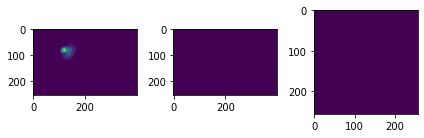

saving directory: all_labels_merged


In [148]:
kls = crop_roi(kora_labels)
volume_3_view_viewer(get_volume_data(kls))
save_volume(kls, f'all_labels_merged/all_kora_labels')

# kls = crop_roi(nako_labels)
# volume_3_view_viewer(get_volume_data(kls))
# save_volume(kls, f'all_labels_merged/all_nako_labels')

# kls = crop_roi(ukb_labels)
# # resample_to_output()
# volume_3_view_viewer(get_volume_data(kls))
# save_volume(kls, f'all_labels_merged/all_ukb_labels')

In [149]:
img = nb.load(f'all_labels_merged/all_kora_labels.nii.gz')
img_data = img.get_fdata()
img_d1, s1,e1, s12, e12 = remove_black(img_data)
img_data1 = np.moveaxis(img_data, 1, 0)
img_d2, s2,e2, s22, e22 = remove_black(img_data1)
img_data2 = np.moveaxis(img_data, 2, 0)
img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# img_data = np.moveaxis(img_data, axis=0)

print('kora', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1,s2,e2,s3,e3,'---', s12,e12,s22,e22,s32,e32)

# img = nb.load(f'all_labels_merged/all_nako_labels.nii.gz')
# img_data = img.get_fdata()
# img_d1,s1,e1, s12, e12 = remove_black(img_data)
# img_data1 = np.moveaxis(img_data, 1, 0)
# img_d2,s2,e2, s22, e22 = remove_black(img_data1)
# img_data2 = np.moveaxis(img_data, 2, 0)
# img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# # img_data = np.moveaxis(img_data, axis=0)

# print('nako', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1,s2,e2,s3,e3,'---', s12,e12,s22,e22,s32,e32)

# img = nb.load(f'all_labels_merged/all_ukb_labels.nii.gz')
# img_data = img.get_fdata()
# img_d1,s1,e1, s12, e12 = remove_black(img_data)
# img_data1 = np.moveaxis(img_data, 1, 0)
# img_d2,s2,e2, s22, e22 = remove_black(img_data1)
# img_data2 = np.moveaxis(img_data, 2, 0)
# img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# # img_data = np.moveaxis(img_data, axis=0)

# print('ukb', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1, s2,e2, s3,e3,'---', s12,e12,s22,e22,s32,e32)

kora (158, 256, 400) (100, 256, 400) (91, 256, 256) 49 206 23 122 84 174 --- 50 205 24 121 85 173


In [ ]:
# KORA = 158,100,91   ---  49, 206, 23, 122, 84, 176  --> 40, 210, 5, 145, 80, 180 == 170, 140, 100  == 176, 144, 112/96  (Multiples of 16)
# NAKO = 158,104,76    --- 44, 201, 40, 143, 169, 244
# UKB= 163, 117, 97    --- 47, 209, 42, 158, 217, 313

# KORA sample vol size = 250, 188, 370
# NAKO sample vol size = 226,184,316
# UKB sample vol size = 246, 137, 239
# sample target shape = 256, 256,400

In [188]:
crop(kora_volumes, [40, 210, 5, 145, 80, 180])

temp/KORA/processed_resized/volume/KORA2453578.nii.gz
saving directory: temp/KORA/processed_resized/volume_cropped
temp/KORA/processed_resized/volume/KORA2459908.nii.gz
saving directory: temp/KORA/processed_resized/volume_cropped
temp/KORA/processed_resized/volume/KORA2462405.nii.gz
saving directory: temp/KORA/processed_resized/volume_cropped
temp/KORA/processed_resized/volume/KORA2458366.nii.gz
saving directory: temp/KORA/processed_resized/volume_cropped
temp/KORA/processed_resized/volume/KORA2456289.nii.gz
saving directory: temp/KORA/processed_resized/volume_cropped
temp/KORA/processed_resized/volume/KORA2453666.nii.gz
saving directory: temp/KORA/processed_resized/volume_cropped
temp/KORA/processed_resized/volume/KORA2452879.nii.gz
saving directory: temp/KORA/processed_resized/volume_cropped
temp/KORA/processed_resized/volume/KORA2459745.nii.gz
saving directory: temp/KORA/processed_resized/volume_cropped
temp/KORA/processed_resized/volume/KORA2460734.nii.gz
saving directory: temp/KOR

In [190]:
crop(kora_labels, [40, 210, 5, 145, 80, 180])

temp/KORA/processed_resized/label/KORA2453578.nii.gz
saving directory: temp/KORA/processed_resized/label_cropped
temp/KORA/processed_resized/label/KORA2459908.nii.gz
saving directory: temp/KORA/processed_resized/label_cropped
temp/KORA/processed_resized/label/KORA2462405.nii.gz
saving directory: temp/KORA/processed_resized/label_cropped
temp/KORA/processed_resized/label/KORA2458366.nii.gz
saving directory: temp/KORA/processed_resized/label_cropped
temp/KORA/processed_resized/label/KORA2456289.nii.gz
saving directory: temp/KORA/processed_resized/label_cropped
temp/KORA/processed_resized/label/KORA2453666.nii.gz
saving directory: temp/KORA/processed_resized/label_cropped
temp/KORA/processed_resized/label/KORA2452879.nii.gz
saving directory: temp/KORA/processed_resized/label_cropped
temp/KORA/processed_resized/label/KORA2459745.nii.gz
saving directory: temp/KORA/processed_resized/label_cropped
temp/KORA/processed_resized/label/KORA2460734.nii.gz
saving directory: temp/KORA/processed_resiz

In [ ]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
#         ONE     : {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }